Vamos a intentar reconstruir el período (`PeriodLS`) de una estrella RRLyrae usando procesos gaussianos.

# Código Auxiliar

## Imports
Pongo los imports acá porque no discutimos organización de código.

In [148]:
import carpyncho
import feets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PyAstronomy.pyasl import foldAt
from sklearn.gaussian_process import GaussianProcessRegressor

## Funciones auxiliares
Defino funciones auxiliares que no sé dónde van porque no discutimos organización de código.

### Manipulación de curvas de luz

In [149]:
class LightCurve:
    """A class for manipulating light curves using hjd and periodic representations simulataneously."""

    def __init__(self, lc, period_catalog, model, seed=999):
        self.period_catalog = period_catalog
        self.model = model

        self.rng = np.random.default_rng(seed)

        lc.sort_values("pwp_stack_src_mag3")
        self.time, self.mag, self.err = (
            lc.pwp_stack_src_hjd.values,
            lc.pwp_stack_src_mag3.values,
            lc.pwp_stack_src_mag_err3.values,
        )
        self.fs = feets.FeatureSpace(only=["PeriodLS", "Period_fit"])
        self.period = period_catalog
        self._make_periodic()

    """Use Lomb-Scargle to obtain the period using the hjd representation."""

    def _calculate_period(self):
        _, values = self.fs.extract(self.time, self.mag, self.err)
        return values[0], values[1]

    """Generate the periodic representation with the current period and the hjd representation."""

    def _make_periodic(self):
        phases = foldAt(self.time, self.period, T0=self.time[0])
        sort = np.argsort(phases)
        self.phases, self.pmag, self.perr = phases[sort], self.mag[sort], self.err[sort]

    """Train the model using the periodic representation."""

    def _train(self):
        self.model.fit(self.phases, self.pmag)

    """Selects a hjd for synthetic observation generation."""

    def _select_hjd(self):
        return self.rng.uniform(low=self.time.min(), high=self.time.max())

    """Returns the phase of the given hjd with the current period."""

    def _hjd_to_phase(self, hjd):
        return np.absolute(hjd - self.time[0]) % self.period

    """Adds an observation to the hjd representation."""

    def _add_hjd_observation(self, hjd, mag, err):
        self.time = np.append(self.time, hjd)
        self.mag = np.append(self.mag, mag)
        self.err = np.append(self.err, err)

    """Generates a single synthetic observation."""

    def _add_single_synthetic(self):
        hjd = self._select_hjd()
        phase = self._hjd_to_phase(hjd)
        mean, std = self.model.predict(np.reshape(phase, (-1, 1)), return_std=True)
        self._add_hjd_observation(hjd, mean[0], std[0])

    """
    Generates n_synthetic observations using a random hjd. pmag and perr are obtained from
    the model.
    """

    def add_synthetic(self, n_synthetic):
        for _ in range(n_synthetic):
            self._add_single_synthetic()

    """
    Calculates the period using the hjd representation. Using both, calculates the periodic representation.
    Returns the calculated period and the period_fit (from Lomb-Scargle).
    """

    def make_periodic(self):
        self.period, period_fit = self._calculate_period()
        self._make_periodic()
        return self.period, period_fit

### Graficación

In [150]:
# Auxiliary plotting functions.

# Given a light curve, plots magnitude vs HJD.
def plot_chronological(lc: LightCurve):

    fig, ax = plt.subplots(figsize=(12, 4))

    ax.errorbar(
        lc.time, lc.mag, lc.err, ls="", marker="o", color="tab:blue", ecolor="tab:red"
    )

    ax.set_title(f"Light Curve")
    ax.set_ylabel("Magnitude")
    ax.set_xlabel("HJD")

    ax.invert_yaxis()
    fig.tight_layout()


# Given a periodic light curve, plots magnitude vs period in two phases.
def plot_periodic(lc: LightCurve):
    # duplicate the values in two phases
    phases = np.hstack((lc.phases, lc.phases + 1))
    pmag = np.hstack((lc.pmag, lc.pmag))
    perr = np.hstack((lc.perr, lc.perr))

    # plot the folded light curve
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.errorbar(
        phases, pmag, perr, ls="", marker="o", ecolor="tab:blue", color="tab:red"
    )
    ax.set_title(f"Folded Light Curve")
    ax.set_ylabel("Magnitude")
    ax.set_xlabel("Phase")
    ax.invert_yaxis()

    fig.tight_layout()

# Reconstrucción de Período

## Obtención de los datos
Primero descargamos el tile `b278` y filtramos las RRLyrae.

In [151]:
# Instance the client and get the b278 tile catalogs.
client = carpyncho.Carpyncho()
b278_lc = client.get_catalog("b278", "lc")
b278_features = client.get_catalog("b278", "features")

# Filter RRLyraes from the catalogs.
periodic_star_types = ["RRLyr-RRab", "RRLyr-RRc", "RRLyr-RRd"]
b278_features = b278_features[b278_features["vs_type"].isin(periodic_star_types)]
b278_lc = b278_lc[b278_lc.bm_src_id.isin(b278_features.id.to_numpy())]

Elegimos la RRLyrae con máxima cantidad de observaciones e inicializamos la clase monstruosa que está arriba.

In [152]:
# Find a star with maximum amount of observations.
star = b278_features.loc[b278_features["cnt"].idxmax()]
# Get the observations for the star.
light_curve = b278_lc[b278_lc.bm_src_id == star.id]

lc = LightCurve(light_curve, star.PeriodLS, GaussianProcessRegressor())

Graficamos la magnitud respecto de la fecha de la observación.

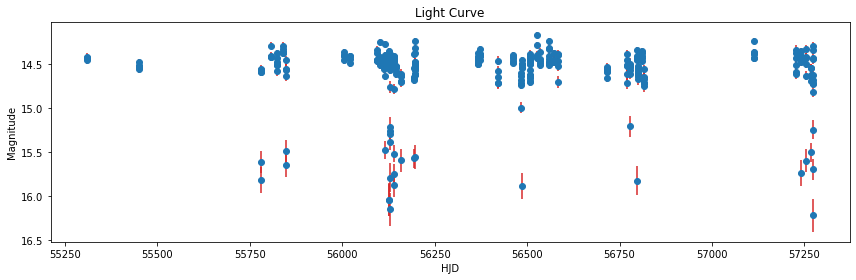

In [153]:
plot_chronological(lc)

Graficamos la magnitud respecto del período que indica `PeriodLS` en el catálogo.

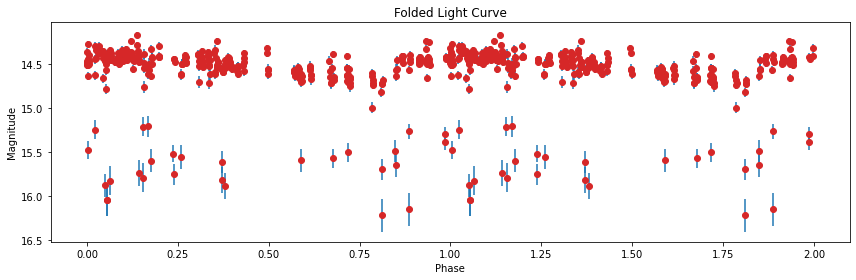

In [154]:
plot_periodic(lc)

🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔

Veamos cuál es el período.

In [155]:
star.PeriodLS

0.5413489533666038

## Reconstrucción del período
Ahora el experimento. Vamos a elegir `n_sample` puntos de la curva de luz al azar y vamos a poner esos puntos en fase usando Lomb-Scargle. Luego vamos a hacer `n_iter` veces lo siguiente:
* Entrenar un proceso gaussiano con los puntos.
* Utilizarlo para agregar `n_synthetic` puntos que se encuentran en un valor al azar (uniformemente distribuido) de la fase.
* Utilizar todos los puntos para recalcular el período usando Lomb-Scargle.
  
Queremos ver si logramos acercarnos al período del catálogo.

In [156]:
# Parameters.
n_sample = 60
n_iter = 20
n_synthetic = 2

In [157]:
%%capture
# TODO: La linea de arriba es porque se me enoja astropy con un deprecation warning que no importa ahora.
period_list = []
period_fit_list = []

sample = light_curve.sample(n=n_sample)
synthetic_lc = LightCurve(sample, star.PeriodLS, GaussianProcessRegressor())

for _ in range(n_iter):
    synthetic_lc.add_synthetic(n_synthetic)
    period, period_fit = synthetic_lc.make_periodic()
    period_list.append(period)
    period_fit_list.append(period_fit)

## Resultados

A ver el período que calculó en cada paso...

In [158]:
period_list

[0.7836927367104235,
 0.9972907023699962,
 0.9971815955703278,
 0.9972907023699962,
 0.9971815955703278,
 0.9971815955703278,
 0.9971815955703278,
 0.4993146004716964,
 0.49928724901046706,
 0.49928724901046706,
 0.4993146004716964,
 0.4993146004716964,
 0.4993146004716964,
 0.4993146004716964,
 0.4993146004716964,
 0.4993146004716964,
 0.4993146004716964,
 0.4993146004716964,
 0.9972907023699962,
 0.9972907023699962]

Da horrible... Se clava en 0.5 o en 1.

In [159]:
period_fit_list

[1.0,
 0.01574255233054378,
 0.014365991620768792,
 5.061548953422257e-05,
 4.657848330813508e-06,
 0.019932821824484748,
 0.002917268583536581,
 0.0014956726572896706,
 0.00046790640172056364,
 6.0559888204081425e-05,
 4.130979088079467e-05,
 9.624894698789799e-05,
 9.269175980430866e-06,
 6.350632428153702e-06,
 4.063825732592008e-07,
 5.234933781683715e-06,
 1.4914132250298806e-05,
 2.133116752800479e-05,
 3.821802030112842e-05,
 6.479206781762059e-06]

🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔

Y si graficamos los puntos queda algo nada que ver (obvio, porque el período no tiene nada que ver con el original).

0.9972907023699962

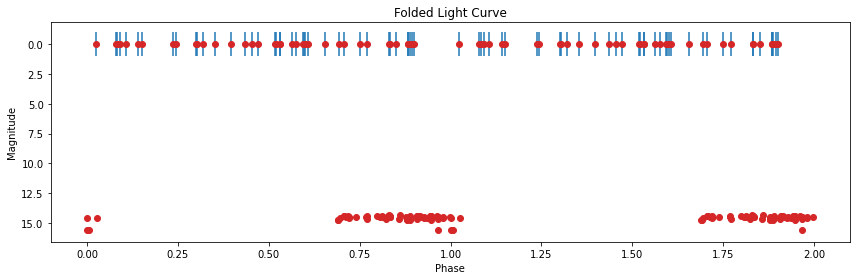

In [160]:
plot_periodic(synthetic_lc)
synthetic_lc.period